# **NVTabular**: Dask-based Data Processing Demo

- **Author**: Rick Zamora (rzamora@nvidia.com)
- **Date**: June 24th 2020 (last update 6/24/2020)

## NVTabular Background

- NVTabular is a feature engineering and preprocessing library for tabular data.  A target application of NVTabular is DL-based recommender system  (RecSys) training and inference, but many other workflows may benefit.
- Built on [RAPIDS](https://rapids.ai/)
- Public GitHub: [NVIDIA/NVTabular](https://github.com/NVIDIA/NVTabular)
- Part of the larger NVIDIA **Merlin** framework [See Merlin Blog for more details.](https://devblogs.nvidia.com/announcing-nvidia-merlin-application-framework-for-deep-recommender-systems/)

![image.png](images/merlin_image.png)

The general motivation of **NVTabular** is to leverage GPUs/CUDA to reduce the time required for the ETL/pre-processing component of the typical DL/ML model-development cycle.  It is established that engineers/scientists can benefit from GPU acceleration while training.  NVTabular hopes to prevent preprocessing from becoming the new bottleneck.

![image.png](images/nvtabular_motivation.png)


The primary goals of **NVTabular** are actually (1) data preprocessing **and** (2) data loading.  In this demo, we are focusing on **Dask-based** preprocessing with NVTabular (we will not touch on the "data-loading" component of NVTabular).


## Brief Usage Overview

**WARNING**: *API is likely to drift a bit over the next 1-2 months.  I will try to update this notebook as those changes happen.*

Usage of the current NVTabular API looks something like the following for a simple preprocessing workflow...

```python
import nvtabular as nvt
import nvtabular

# Step 1: Initialize workflow with dataset details
workflow = nvt.Workflow(
    client=DASK_CLIENT,
    cat_names=CATEGORICAL_COLUMN_NAME,
    cont_names=CONTINUOUS_COLUMN_NAME,
    label_name=LABEL_COLUMN_NAME,
)

# Step 2: Add feature-engineering and transform operations
workflow.add_feature([ops.ZeroFill(), ops.LogOp()])
workflow.add_preprocess(ops.Categorify())
workflow.finalize()

# Step 3: Create a "dataset" object for the workflow to "process"
dataset = nvt.DaskDataset(DATSET_PATH, engine="parquet", part_mem_fraction=0.2)

# Step 4: Compute statistics and write shuffled/processed dataset
workflow.apply(dataset, shuffle="full", output_path="./proc")
```

The overall procedure in the above code snippet is:
 
- **Step 1**: Initialize an nvtabular `Workflow` object.  The user must distinguish the categorical and continuous columns.  A dask `client` is also needed to leverage the `dask_cudf` backend.
- **Step 2**: Add feature-engineering operations (add new columns without changing original columns), and general pre-processing operations to the workflow.  If/when these operations require global statistics, additional "statistics" operators will be added to the workflow automatically.
- **Step 3**: Create a "dataset" object to be operated on by the workflow.  The purpose of `DaskDataset` is to allow the workflow to effectively materialize a distributed `dask_cudf.DataFrame` object as needed.
- **Step 4**: Execute the workflow.  May include full shuffling/transformation of data (like in the above example), but can also just collect underlying statistics if transformation will be performed "online".


## Brief Algorithm Overview

Under the hood, NVTabular will use the `workflow` definition to compile an internal `phases` data structure.  For the above example, `phases` will be a list of length two (two "phases" means two global passes over the data):

```
# phases[0]:

[(<nvtabular.ops.Encoder at 0x7f3964e84390>, 'categorical', ['base'], [])]

# phases[1]:

[(<nvtabular.ops.ZeroFill at 0x7f3964e84a50>, 'continuous', ['base'], []),
 (<nvtabular.ops.LogOp at 0x7f3964e84250>, 'continuous', ['ZeroFill'], []),
 (<nvtabular.ops.Categorify at 0x7f3964e84ad0>,
  'categorical',
  ['base'],
  [<nvtabular.ops.Encoder at 0x7f3964e84310>])]
```

In this example, phase-0 is only for the `Encoder` *statistics* operation, and phase-1 is for all other (transform) operations.  However, there is no rule that *statistics* operations and *transform* operations must happened in distinct phases.  Instead, the actual procedure for a single phase looks something like this:

```python
def exec_phase(self, phase_index, record_stats=True):
    """
    Code copied from NVTabular/nvtabular/workflow.py

    Gather necessary column statistics in single pass.
    Execute one phase only, given by phase index
    """
    transforms = []
    for task in self.phases[phase_index]:
        op, cols_grp, target_cols, _ = task
        if isinstance(op, TransformOperator):
            stats_context = self.stats if isinstance(op, DFOperator) else None
            logic = op.apply_op
            transforms.append(
                (self.columns_ctx, cols_grp, target_cols, logic, stats_context)
            )
        elif not isinstance(op, StatOperator):
            raise ValueError("Unknown Operator Type")

    # Preform transforms as single dask task (per ddf partition)
    if transforms:
        self._aggregated_dask_transform(transforms)

    stats = []
    if record_stats:
        for task in self.phases[phase_index]:
            op, cols_grp, target_cols, _ = task
            if isinstance(op, StatOperator):
                stats.append(
                    (
                        op.dask_logic(
                            self.get_ddf(),
                            self.columns_ctx,
                            cols_grp,
                            target_cols,
                        ), 
                        op,
                    )
                )

    # Compute statistics if necessary
    if stats:
        for r in self.client.compute(stats):
            computed_stats, op = r.result()
            op.dask_fin(computed_stats)
            self._update_stats(op)
            op.clear()
        del stats
```

The general summary of `exec_phase` is that *all* transform operators are bundled together and executed with a (lazy) `map_partitions` call, and then all statistics are separately bundled together and computed. This effectively means that transform ops are never computed until absolutely necessary, while statistics operations are always computed immediately. 

## **Real Example**: Criteo DLRM Preprocessing
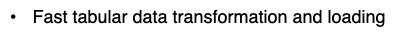

In [1]:
import glob
import cudf
import dask_cudf

from dask_cuda import LocalCUDACluster
from dask.distributed import Client, performance_report
from dask.utils import parse_bytes

import nvtabular.ops as ops
import nvtabular as nvt

In [2]:
# Cleanup working space and spin up a LocalCUDACluster

!rm -rf /raid/dask-space/rzamora/*
!mkdir /raid/dask-space/rzamora/scratch
worker_dir = "/raid/dask-space/rzamora"

protocol = "tcp"                    # "tcp" or "ucx"
visible_devices = "0,1,2,3,4,5,6,7" # Delect devices to place workers
device_memory_limit = "28GB"        # Spill device mem to host at this limit
memory_limit = "96GB"               # Spill host mem to disk near this limit

cluster = LocalCUDACluster(
    protocol = protocol,
    CUDA_VISIBLE_DEVICES = visible_devices,
    local_directory = worker_dir,
    device_memory_limit = parse_bytes(device_memory_limit),
    memory_limit = parse_bytes(memory_limit),
)
client = Client(cluster)

client.run(
    cudf.set_allocator,
    pool=True,
    initial_pool_size=parse_bytes(device_memory_limit),
    allocator="default"
)
client

Client Scheduler: tcp://127.0.0.1:46761 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 768.00 GB


In [3]:
# Specify preprocessing options/input

data_path = "/raid/dask-space/criteo/crit_pq_int"  # Criteo Dataset (in parquet format)
out_path = worker_dir + "/scratch"                 # Write output within the dask-worker space     
nsplits = 24                                       # (Per-worker) file count for partial shuffle
split_out = 8                                      # Number of hash splits for groupby reductions
cat_cache = "host"                                 # Where to cache categories between transform ops
on_host = True                                     # Move data to host between Groupby tasks
part_mem_fraction = 0.2                            # Size of each dask partition (fraction of device)

cont_names = ['I' + str(x) for x in range(1,14)]
cat_names =  ['C' + str(x) for x in range(1,27)]
label_name = ["label"]

In [4]:
# Since this is a demo, lets use a subset of columns
# (Full dataset should work fine, but takes a couple minutes longer)

cont_names = cont_names[:4]
cat_names = cat_names[:4]

# Save list of all columns for convenience
columns=cat_names + cont_names + label_name

Here we define a `Workflow` as in the simple example above.  However, we are now including arguments to the `Categorify` operation.  The meaning of these options will be discussed below.

In [5]:
# Define NVTabular Workflow

workflow = nvt.Workflow(
    client=client,
    cat_names=cat_names,
    cont_names=cont_names,
    label_name=label_name,
)

workflow.add_feature([ops.ZeroFill(), ops.LogOp()])

workflow.add_preprocess(
    ops.Categorify(
        out_path=out_path,
        split_out=split_out,
        cat_cache=cat_cache,
        on_host=on_host,
    )
)
workflow.finalize()

In [6]:
# Define a `dataset` object for the `workflow` to operate on

dataset = nvt.DaskDataset(data_path, engine="parquet", part_mem_fraction=part_mem_fraction)

It is worth highlighting that `DaskDataset` *should* eventually become a thin wrapper around `dask_cudf.read_parquet/csv/orc`.  However, for performance reasons, we have temporarily implemented a replacement for `dask_cudf.read_parquet`.  Once reason is that we want to allow cudf to read multiple row-groups at once (which `dask_cudf`/`dask.dataframe` doesn't allow **yet**).  The other reason is related to the "planning" stage of the read...

Within NVTabular, it is important that the client be able to **quickly** construct a new `dask_cudf.DataFrame`, with a specified partition size, on demand.  That is, the following behavior is necessary:

In [7]:
%time dataset.to_ddf(columns=columns)

CPU times: user 37.1 ms, sys: 27.7 ms, total: 64.9 ms
Wall time: 59 ms


,C1,C2,C3,C4,I1,I2,I3,I4,label
npartitions=156,,,,,,,,,
,int32,int32,int32,int32,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


This is currently a challenge for `dask_cudf.read_parquet`.  Even if we **don't** use the `chunksize` argument, partitioning by row-group is already painfully slow...

In [8]:
%time dask_cudf.read_parquet(data_path, columns=columns)

CPU times: user 51.6 s, sys: 2.55 s, total: 54.1 s
Wall time: 47.6 s


,C1,C2,C3,C4,I1,I2,I3,I4,label
npartitions=6337,,,,,,,,,
,int32,int32,int32,int32,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


The good news is that the reason(s) for the poor performance of `dask_cudf.read_parquet` **can** be resolved, and I am currently working on them :)

**Finally, executing the workflow:**

In [9]:
%%time
workflow.apply(dataset, shuffle="full", nsplits=nsplits, output_path=out_path)

CPU times: user 7.67 s, sys: 703 ms, total: 8.37 s
Wall time: 1min 6s


In [10]:
# Check that the first row-group of the output dataset looks "processed"

cudf.io.read_parquet(
    glob.glob(worker_dir + "/scratch/processed/*")[0],
    row_group=0,
).head()

,I1,I2,I3,I4,C1,C2,C3,C4,label
0,1.791759,5.424950,3.044523,0.000000,106215871,37607,1,5877,0
1,2.079442,5.010635,0.000000,0.000000,192250877,28189,8934,3304,0
2,1.791759,5.420535,0.000000,2.302585,66120273,25,15210,3304,0
3,0.000000,5.726848,0.000000,0.000000,40551666,11989,1597,6637,0
4,4.477337,6.390241,0.000000,6.586172,31075927,24231,6273,6713,0


## Lessons Learned for `dask`/`dask_cudf`

- `read_parquet` performance needs work (performance improvements are in progress here)
- `cudf`'s chunked parquet writer and `cudf`'s ability to write-to/read-from a `BytesIO` object allows per-worker data shuffling to avoid communication and device memory pressure.
- `groupby`-based statistics required the implementation of a custom dask-based groupby algorithm.
- For categorical encoding, the fastest caching strategy for the categorical labels required writing-to and reading-from a `BytesIO` objects in host memory.

### `read_parquet` Performance

As mentioned above, this issue will be resolved in the near future. `dask.dataframe` currently combines row-group statistics gathering with row-group splitting in an unnecessary way.  There is also some very slow code in the statistics processing.


### Shuffling with "Chunked" Parquet

Although a *true* shuffle will be implemented/included in the near future,  the need for a "stable" shuffling approach (with limited global device memory) has led to "full" and "partial" **per-worker** shuffling for now.  For example, the "full" per-worker shuffle will perform a full shuffle of all data transformed by **that** worker (no mixing between workers).  This approach may be sufficient for may applications, but we will certainly provide a **true** shuffle for users who need it.

![image.png](images/per_worker_shuffle.png)


### Custom `groupby` Implementation for Categorical Encoding

Since dataset statistics are (or *should* be) persisted to disk in NVTabular.  We want a Dask-based `groupby` operation to simply return the path of the parquet file where groupby statistics have been written for a specific categorical column (or combination of columns). This *can* be accomplished with the existing `dask_cudf`/`dask.dataframe` API (by using specific `split_every`/`split_out` parameters and adding a delayed `cudf.to_parquet` for each result), but our "custom" implementation has provided better stability and performance.  The reasons for this:

- We are using a simple hash-based tree reduction for each categorical column. The user can specify a different number of hash partitions (width of the tree) for each column if necessary.
- The groupby operation for all categorical columns will share the same "top-level" task for each ddf partition.
- The final parquet write is included within the leaf nodes of the simple tree reduction (reducing the number of overall tasks).
- For systems with limited device memory, the `on_host=True` option can be used to dramatically reduce memory pressure.  This will convert cudf DataFrames to pandas **between** tree nodes, and leave the data in pandas format for initial `concat` operations.


For example, some of the relevant code is copied here:


```python
def _top_level_groupby(gdf, cat_cols, split_out, cont_cols, sum_sq, on_host):
    # Top-level operation for category-based groupby aggregations
    output = {}
    k = 0
    for i, cat_col in enumerate(cat_cols):

        # Compile aggregation dictionary and add "squared-sum"
        # column(s) (necessary when `cont_cols` is non-empty)
        df_gb = gdf[[cat_col] + cont_cols].copy(deep=False)
        agg_dict = {}
        agg_dict[cat_col] = ["count"]
        for col in cont_cols:
            agg_dict[col] = ["sum"]
            if sum_sq:
                name = _make_name(col, "pow2")
                df_gb[name] = df_gb[col].pow(2)
                agg_dict[name] = ["sum"]

        # Perform groupby and flatten column index
        # (flattening provides better cudf support)
        gb = df_gb.groupby(cat_col, dropna=False).agg(agg_dict)
        gb.columns = [
            _make_name(*name)
            if name[0] == cat_col
            else _make_name(*((cat_col,) + name))
            for name in gb.columns.to_flat_index()
        ]
        gb.reset_index(inplace=True, drop=False)
        del df_gb

        # Split the result by the hash value of the categorical column
        for j, split in enumerate(
            gb.partition_by_hash(
                [cat_col], split_out[cat_col], keep_index=False
            )
        ):
            if on_host:
                output[k] = split.to_pandas()
            else:
                output[k] = split
            k += 1
        del gb
    return output


def _mid_level_groupby(dfs, col, cont_cols, agg_list, freq_limit, on_host):
    ignore_index = True
    if on_host:
        gb = cudf.from_pandas(
            _concat(dfs, ignore_index)
        ).groupby(col, dropna=False).sum()
    else:
        gb = _concat(dfs, ignore_index).groupby(col, dropna=False).sum()
    gb.reset_index(drop=False, inplace=True)

    name_count = _make_name(col, "count")
    if freq_limit:
        gb = gb[gb[name_count] >= freq_limit]

    required = [col]
    if "count" in agg_list:
        required.append(name_count)
        
    ...
```


### Parquet + BytesIO Proved Most efficient for Category Caching 

When applying the `Categorify` operation, a dask worker will need to read in the categorical labels for each column within each transformation task.  Since the worker will be reading the same data many times, there is an obvious opportunity to cache data in host and device memory.

Although we tried a variety of techniques to implement host-memory caching, the clear performance winner was `read_parquet` + `BytesIO`.  For example, the relevant code is copied below...


```python
def get_categories(self, col, path, cache="disk"):
    table = self.cat_cache.get(col, None)
    if table and not isinstance(table, cudf.DataFrame):
        df = cudf.io.read_parquet(table, index=False, columns=[col])
        df.index.name = "labels"
        df.reset_index(drop=False, inplace=True)
        return df

    if table is None:
        if cache in ("device", "disk"):
            table = cudf.io.read_parquet(path, index=False, columns=[col])
        elif cache == "host":
            with open(path, "rb") as f:
                self.cat_cache[col] = BytesIO(f.read())
            table = cudf.io.read_parquet(self.cat_cache[col], index=False, columns=[col])
        table.index.name = "labels"
        table.reset_index(drop=False, inplace=True)
        if cache == "device":
            self.cat_cache[col] = table.copy(deep=False)
    return table
```


# Thanks!

Please feel free to contact me directly with comments/suggestions/questions.  Also, NVTabular (especially the dask-based backend) is still a work in progress, so this notebook is likely to become obsolete fairly quickly (sorry in advance).